In [1]:
from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import wrf
import seaborn as sns
import pandas as pd
import cartopy
import cartopy.crs as ccrs
from metpy.plots import USCOUNTIES

mpl.rcParams['font.size'] = 14

In [2]:
surf_layer = 1
high_layer = 8
# filepath = f"/data/keeling/a/xx24/d/cares_output/"

In [3]:
file = xr.open_dataset("~/d/cares_output/00/map_001_001_001_00000037.nc")
sc_edges = file['sc_edges']
diam_edges = file['diam_edges']
ratio1 = np.log(sc_edges[1]/sc_edges[0])
ratio2 = np.log(diam_edges[1]/diam_edges[0])
cell = ratio1*ratio2

In [4]:
from netCDF4 import Dataset
wrfout = Dataset('/data/keeling/a/jcurtis2/d/bridges2_big_run/aerosols_d01_2010-06-17_00:00:00', "r", format="NETCDF4")
ozone = wrf.getvar(wrfout, "o3")
lats, lons = wrf.latlon_coords(ozone)
lats = wrf.to_np(lats)
lons = wrf.to_np(lons)

In [5]:
def nc_shape(var):
    da = xr.DataArray(
        data=var.T,
        dims=["south_north", "west_east"],
        coords=dict(
            lon=(["south_north", "west_east"], lons),
            lat=(["south_north", "west_east"], lats),
        ),
        attrs=dict(
            description="var",
            units="1",
        ),
    )
    return da

In [6]:
def rel_err(var_cs, var_vs):
    if np.any(var_vs == 0):
        result = np.zeros_like(var_cs)
    else:
        result = (var_cs - var_vs) / var_vs
    return  - result*100

def diam_sc(filename, var, a, b):  
    before_compress = np.sum(filename[var][:19], axis=0)
    result = sum(before_compress[a:b])
    return result*cell

In [7]:
from joblib import Parallel, delayed

In [8]:
diam_sc_cs_40     = np.empty((169, 159))
diam_sc_cs_70     = np.empty((169, 159))
diam_sc_cs_100    = np.empty((169, 159))
diam_sc_vs_40     = np.empty((169, 159))
diam_sc_vs_70     = np.empty((169, 159))
diam_sc_vs_100    = np.empty((169, 159))

# And for the 1-km (high) layer group:
diam_sc_cs_40_1km = np.empty((169, 159))
diam_sc_cs_70_1km = np.empty((169, 159))
diam_sc_cs_100_1km= np.empty((169, 159))
diam_sc_vs_40_1km = np.empty((169, 159))
diam_sc_vs_70_1km = np.empty((169, 159))
diam_sc_vs_100_1km= np.empty((169, 159))


def process_file(i, j, layer):
    """
    Reads one NetCDF file, computes the 6 diam_sc values, and returns them.
    """
    filename = f"/data/keeling/a/xx24/d/cares_output/00/map_{i:03d}_{j:03d}_{layer:03d}_{37:08d}.nc"

    # It's good practice to use a context manager so the file is closed after reading
    with xr.open_dataset(filename) as ds:
        val_cs_40  = diam_sc(ds, 'diam_sc_dist', 30, 48)
        val_cs_70  = diam_sc(ds, 'diam_sc_dist', 48, 57)
        val_cs_100 = diam_sc(ds, 'diam_sc_dist', 57, 60)
        
        val_vs_40  = diam_sc(ds, 'diam_sc_varying_sigma_dist', 30, 48)
        val_vs_70  = diam_sc(ds, 'diam_sc_varying_sigma_dist', 48, 57)
        val_vs_100 = diam_sc(ds, 'diam_sc_varying_sigma_dist', 57, 60)

    # Return a tuple that includes the indices and values
    return (
        i, j, 
        val_cs_40,  val_cs_70,  val_cs_100, 
        val_vs_40,  val_vs_70,  val_vs_100
    )

# Number of jobs = number of CPU cores you want to use
n_jobs = 8  

results_surf = Parallel(n_jobs=n_jobs)(
    delayed(process_file)(i, j, surf_layer) 
    for i in range(1, 170)
    for j in range(1, 160)
)

for (i, j, 
     val_cs_40, val_cs_70, val_cs_100, 
     val_vs_40, val_vs_70, val_vs_100) in results_surf:
    
    # Remember: i, j run from 1..169 and 1..159, so subtract 1 for zero-based index
    diam_sc_cs_40[i-1, j-1]  = val_cs_40
    diam_sc_cs_70[i-1, j-1]  = val_cs_70
    diam_sc_cs_100[i-1, j-1] = val_cs_100
    
    diam_sc_vs_40[i-1, j-1]  = val_vs_40
    diam_sc_vs_70[i-1, j-1]  = val_vs_70
    diam_sc_vs_100[i-1, j-1] = val_vs_100

results_high = Parallel(n_jobs=n_jobs)(
    delayed(process_file)(i, j, high_layer) 
    for i in range(1, 170)
    for j in range(1, 160)
)

for (i, j, 
     val_cs_40, val_cs_70, val_cs_100, 
     val_vs_40, val_vs_70, val_vs_100) in results_high:
    
    diam_sc_cs_40_1km[i-1, j-1]  = val_cs_40
    diam_sc_cs_70_1km[i-1, j-1]  = val_cs_70
    diam_sc_cs_100_1km[i-1, j-1] = val_cs_100
    
    diam_sc_vs_40_1km[i-1, j-1]  = val_vs_40
    diam_sc_vs_70_1km[i-1, j-1]  = val_vs_70
    diam_sc_vs_100_1km[i-1, j-1] = val_vs_100

In [33]:
diam_sc_cs_12_40     = np.empty((169, 159))
diam_sc_cs_12_70     = np.empty((169, 159))
diam_sc_cs_12_100    = np.empty((169, 159))
diam_sc_vs_12_40     = np.empty((169, 159))
diam_sc_vs_12_70     = np.empty((169, 159))
diam_sc_vs_12_100    = np.empty((169, 159))

diam_sc_cs_12_40_1km = np.empty((169, 159))
diam_sc_cs_12_70_1km = np.empty((169, 159))
diam_sc_cs_12_100_1km= np.empty((169, 159))
diam_sc_vs_12_40_1km = np.empty((169, 159))
diam_sc_vs_12_70_1km = np.empty((169, 159))
diam_sc_vs_12_100_1km= np.empty((169, 159))

def process_file_12(i, j, layer):
    """
    Opens the NetCDF file for the given i, j, and layer (surf_layer or high_layer).
    Returns a tuple of (i, j, val_cs_40, val_cs_70, val_cs_100, val_vs_40, val_vs_70, val_vs_100).
    """
    filename = f"/data/keeling/a/xx24/d/cares_output/12/map_{i:03d}_{j:03d}_{layer:03d}_{12:08d}.nc"

    # Use a context manager so the file is closed immediately after reading
    with xr.open_dataset(filename) as ds:
        val_cs_40  = diam_sc(ds, 'diam_sc_dist',               30, 48)
        val_cs_70  = diam_sc(ds, 'diam_sc_dist',               48, 57)
        val_cs_100 = diam_sc(ds, 'diam_sc_dist',               57, 60)
        val_vs_40  = diam_sc(ds, 'diam_sc_varying_sigma_dist', 30, 48)
        val_vs_70  = diam_sc(ds, 'diam_sc_varying_sigma_dist', 48, 57)
        val_vs_100 = diam_sc(ds, 'diam_sc_varying_sigma_dist', 57, 60)

    return (i, j, val_cs_40, val_cs_70, val_cs_100, val_vs_40, val_vs_70, val_vs_100)

n_jobs = 8  # Number of CPU cores (or processes) to use

# Run parallel for the surface layer
results_12_surf = Parallel(n_jobs=n_jobs)(
    delayed(process_file_12)(i, j, surf_layer) 
    for i in range(1, 170)
    for j in range(1, 160)
)

# Place the results into your arrays
for (i, j, 
     val_cs_40, val_cs_70, val_cs_100, 
     val_vs_40, val_vs_70, val_vs_100) in results_12_surf:
    
    # Convert to zero-based indices
    ii, jj = i - 1, j - 1

    diam_sc_cs_12_40[ii, jj]   = val_cs_40
    diam_sc_cs_12_70[ii, jj]   = val_cs_70
    diam_sc_cs_12_100[ii, jj]  = val_cs_100

    diam_sc_vs_12_40[ii, jj]   = val_vs_40
    diam_sc_vs_12_70[ii, jj]   = val_vs_70
    diam_sc_vs_12_100[ii, jj]  = val_vs_100

results_12_high = Parallel(n_jobs=n_jobs)(
    delayed(process_file_12)(i, j, high_layer) 
    for i in range(1, 170)
    for j in range(1, 160)
)

for (i, j, 
     val_cs_40, val_cs_70, val_cs_100, 
     val_vs_40, val_vs_70, val_vs_100) in results_12_high:
    
    ii, jj = i - 1, j - 1

    diam_sc_cs_12_40_1km[ii, jj]  = val_cs_40
    diam_sc_cs_12_70_1km[ii, jj]  = val_cs_70
    diam_sc_cs_12_100_1km[ii, jj] = val_cs_100

    diam_sc_vs_12_40_1km[ii, jj]  = val_vs_40
    diam_sc_vs_12_70_1km[ii, jj]  = val_vs_70
    diam_sc_vs_12_100_1km[ii, jj] = val_vs_100    

In [9]:
pd.DataFrame(diam_sc_cs_40).to_csv('ccn_cs_40',index=False, header=False)
pd.DataFrame(diam_sc_cs_70).to_csv('ccn_cs_70',index=False, header=False)
pd.DataFrame(diam_sc_cs_100).to_csv('ccn_cs_100',index=False, header=False)
pd.DataFrame(diam_sc_vs_40).to_csv('ccn_vs_40',index=False, header=False)
pd.DataFrame(diam_sc_vs_70).to_csv('ccn_vs_70',index=False, header=False)
pd.DataFrame(diam_sc_vs_100).to_csv('ccn_vs_100',index=False, header=False)

pd.DataFrame(diam_sc_cs_40_1km).to_csv('ccn_cs_40_1km',index=False, header=False)
pd.DataFrame(diam_sc_cs_70_1km).to_csv('ccn_cs_70_1km',index=False, header=False)
pd.DataFrame(diam_sc_cs_100_1km).to_csv('ccn_cs_100_1km',index=False, header=False)
pd.DataFrame(diam_sc_vs_40_1km).to_csv('ccn_vs_40_1km',index=False, header=False)
pd.DataFrame(diam_sc_vs_70_1km).to_csv('ccn_vs_70_1km',index=False, header=False)
pd.DataFrame(diam_sc_vs_100_1km).to_csv('ccn_vs_100_1km',index=False, header=False)

In [34]:
pd.DataFrame(diam_sc_cs_12_40).to_csv('ccn_cs_12_40',index=False, header=False)
pd.DataFrame(diam_sc_cs_12_70).to_csv('ccn_cs_12_70',index=False, header=False)
pd.DataFrame(diam_sc_cs_12_100).to_csv('ccn_cs_12_100',index=False, header=False)
pd.DataFrame(diam_sc_vs_12_40).to_csv('ccn_vs_12_40',index=False, header=False)
pd.DataFrame(diam_sc_vs_12_70).to_csv('ccn_vs_12_70',index=False, header=False)
pd.DataFrame(diam_sc_vs_12_100).to_csv('ccn_vs_12_100',index=False, header=False)

pd.DataFrame(diam_sc_cs_12_40_1km).to_csv('ccn_cs_12_40_1km',index=False, header=False)
pd.DataFrame(diam_sc_cs_12_70_1km).to_csv('ccn_cs_12_70_1km',index=False, header=False)
pd.DataFrame(diam_sc_cs_12_100_1km).to_csv('ccn_cs_12_100_1km',index=False, header=False)
pd.DataFrame(diam_sc_vs_12_40_1km).to_csv('ccn_vs_12_40_1km',index=False, header=False)
pd.DataFrame(diam_sc_vs_12_70_1km).to_csv('ccn_vs_12_70_1km',index=False, header=False)
pd.DataFrame(diam_sc_vs_12_100_1km).to_csv('ccn_vs_12_100_1km',index=False, header=False)

In [7]:
# surface
sc_cs = pd.read_csv('ccn_cs_00', sep=',', header=None)
sc_vs = pd.read_csv('ccn_vs_00', sep=',', header=None)
# 1km
sc_cs_1km = pd.read_csv('ccn_cs_00_1km', sep=',', header=None)
sc_vs_1km = pd.read_csv('ccn_vs_00_1km', sep=',', header=None)

sc_error = rel_err(sc_cs,sc_vs)
sc_error_1km = rel_err(sc_cs_1km,sc_vs_1km)

In [8]:
sc_cs_12 = pd.read_csv('ccn_cs_12', sep=',', header=None)
sc_vs_12 = pd.read_csv('ccn_vs_12', sep=',', header=None)

sc_cs_12_1km = pd.read_csv('ccn_cs_12_1km', sep=',', header=None)
sc_vs_12_1km = pd.read_csv('ccn_vs_12_1km', sep=',', header=None)

sc_error_12 = rel_err(sc_cs_12,sc_vs_12)
sc_error_12_1km = rel_err(sc_cs_12_1km,sc_vs_12_1km)

In [9]:
diam_sc_cs_40  = pd.read_csv('ccn_cs_40' , sep=',', header=None)
diam_sc_cs_70  = pd.read_csv('ccn_cs_70' , sep=',', header=None)
diam_sc_cs_100 = pd.read_csv('ccn_cs_100', sep=',', header=None)
diam_sc_vs_40  = pd.read_csv('ccn_vs_40' , sep=',', header=None)
diam_sc_vs_70  = pd.read_csv('ccn_vs_70' , sep=',', header=None)
diam_sc_vs_100 = pd.read_csv('ccn_vs_100', sep=',', header=None)

diam_sc_cs_40_1km  = pd.read_csv('ccn_cs_40_1km' , sep=',', header=None)
diam_sc_cs_70_1km  = pd.read_csv('ccn_cs_70_1km' , sep=',', header=None)
diam_sc_cs_100_1km = pd.read_csv('ccn_cs_100_1km', sep=',', header=None)
diam_sc_vs_40_1km  = pd.read_csv('ccn_vs_40_1km' , sep=',', header=None)
diam_sc_vs_70_1km  = pd.read_csv('ccn_vs_70_1km' , sep=',', header=None)
diam_sc_vs_100_1km = pd.read_csv('ccn_vs_100_1km', sep=',', header=None)

In [10]:
diam_sc_cs_12_40 = pd.read_csv('ccn_cs_12_40' , sep=',', header=None)
diam_sc_cs_12_70 = pd.read_csv('ccn_cs_12_70' , sep=',', header=None)
diam_sc_cs_12_100 =pd.read_csv('ccn_cs_12_100', sep=',', header=None)
diam_sc_vs_12_40 = pd.read_csv('ccn_vs_12_40' , sep=',', header=None)
diam_sc_vs_12_70 = pd.read_csv('ccn_vs_12_70' , sep=',', header=None)
diam_sc_vs_12_100 =pd.read_csv('ccn_vs_12_100', sep=',', header=None)

diam_sc_cs_12_40_1km = pd.read_csv('ccn_cs_12_40_1km' , sep=',', header=None)
diam_sc_cs_12_70_1km = pd.read_csv('ccn_cs_12_70_1km' , sep=',', header=None)
diam_sc_cs_12_100_1km =pd.read_csv('ccn_cs_12_100_1km', sep=',', header=None)
diam_sc_vs_12_40_1km = pd.read_csv('ccn_vs_12_40_1km' , sep=',', header=None)
diam_sc_vs_12_70_1km = pd.read_csv('ccn_vs_12_70_1km' , sep=',', header=None)
diam_sc_vs_12_100_1km =pd.read_csv('ccn_vs_12_100_1km', sep=',', header=None)

In [11]:
diam_sc_40_error = rel_err(diam_sc_cs_40, diam_sc_vs_40)
diam_sc_70_error = rel_err(diam_sc_cs_70, diam_sc_vs_70)
diam_sc_100_error = rel_err(diam_sc_cs_100, diam_sc_vs_100)
diam_sc_40_error_1km = rel_err(diam_sc_cs_40_1km, diam_sc_vs_40_1km)
diam_sc_70_error_1km = rel_err(diam_sc_cs_70_1km, diam_sc_vs_70_1km)
diam_sc_100_error_1km = rel_err(diam_sc_cs_100_1km, diam_sc_vs_100_1km)

In [12]:
diam_sc_12_40_error = rel_err(diam_sc_cs_12_40, diam_sc_vs_12_40)
diam_sc_12_70_error = rel_err(diam_sc_cs_12_70, diam_sc_vs_12_70)
diam_sc_12_100_error = rel_err(diam_sc_cs_12_100, diam_sc_vs_12_100)
diam_sc_12_40_error_1km = rel_err(diam_sc_cs_12_40_1km, diam_sc_vs_12_40_1km)
diam_sc_12_70_error_1km = rel_err(diam_sc_cs_12_70_1km, diam_sc_vs_12_70_1km)
diam_sc_12_100_error_1km = rel_err(diam_sc_cs_12_100_1km, diam_sc_vs_12_100_1km)

In [16]:
sc_error_compare = pd.DataFrame({
    'error': np.concatenate([sc_error.values.ravel(), sc_error_1km.values.ravel()]),
    'type': ['surface']*len(sc_error.values.ravel()) + ['1 km']*len(sc_error_1km.values.ravel())
})

sc_40_error_compare = pd.DataFrame({
    'error': np.concatenate([diam_sc_40_error.flatten(), diam_sc_40_error_1km.flatten()]),
    'type': ['surface'] * len(diam_sc_40_error.flatten()) + ['1 km'] * len(diam_sc_40_error_1km.flatten()),
    'diam_range': ['10-40 nm'] * (len(diam_sc_40_error.flatten()) + len(diam_sc_40_error_1km.flatten()))
})

sc_70_error_compare = pd.DataFrame({
    'error': np.concatenate([diam_sc_70_error.values.ravel(), diam_sc_70_error_1km.values.ravel()]),
    'type': ['surface'] * len(diam_sc_70_error.values.ravel()) + ['1 km'] * len(diam_sc_70_error_1km.values.ravel()),
    'diam_range': ['40-70 nm'] * (len(diam_sc_70_error.values.ravel()) + len(diam_sc_70_error_1km.values.ravel()))
})

sc_100_error_compare = pd.DataFrame({
    'error': np.concatenate([diam_sc_100_error.values.ravel(), diam_sc_100_error_1km.values.ravel()]),
    'type': ['surface'] * len(diam_sc_100_error.values.ravel()) + ['1 km'] * len(diam_sc_100_error_1km.values.ravel()),
    'diam_range': ['70-100 nm'] * (len(diam_sc_100_error.values.ravel()) + len(diam_sc_100_error_1km.values.ravel()))
})

df_combined = pd.concat([sc_40_error_compare, sc_70_error_compare, sc_100_error_compare], ignore_index=True)
df_combined

,error,type,diam_range
0,-0.000000,surface,10-40 nm
1,-0.000000,surface,10-40 nm
2,-0.000000,surface,10-40 nm
3,-0.000000,surface,10-40 nm
4,-0.000000,surface,10-40 nm
...,...,...,...
161221,8.823529,1 km,70-100 nm
161222,5.263158,1 km,70-100 nm
161223,15.789474,1 km,70-100 nm
161224,14.285714,1 km,70-100 nm


In [17]:
sc_error_compare_12 = pd.DataFrame({
    'error': np.concatenate([sc_error_12.values.ravel(), sc_error_12_1km.values.ravel()]),
    'type': ['surface']*len(sc_error_12.values.ravel()) + ['1 km']*len(sc_error_12_1km.values.ravel())
})

sc_40_error_compare_12 = pd.DataFrame({
    'error': np.concatenate([diam_sc_12_40_error.flatten(), diam_sc_12_40_error_1km.flatten()]),
    'type': ['surface'] * len(diam_sc_12_40_error.flatten()) + ['1 km'] * len(diam_sc_12_40_error_1km.flatten()),
    'diam_range': ['10-40 nm'] * (len(diam_sc_12_40_error.flatten()) + len(diam_sc_12_40_error_1km.flatten()))
})

sc_70_error_compare_12 = pd.DataFrame({
    'error': np.concatenate([diam_sc_12_70_error.values.ravel(), diam_sc_12_70_error_1km.values.ravel()]),
    'type': ['surface'] * len(diam_sc_12_70_error.values.ravel()) + ['1 km'] * len(diam_sc_12_70_error_1km.values.ravel()),
    'diam_range': ['40-70 nm'] * (len(diam_sc_12_70_error.values.ravel()) + len(diam_sc_12_70_error_1km.values.ravel()))
})

sc_100_error_compare_12 = pd.DataFrame({
    'error': np.concatenate([diam_sc_12_100_error.values.ravel(), diam_sc_12_100_error_1km.values.ravel()]),
    'type': ['surface'] * len(diam_sc_12_100_error.values.ravel()) + ['1 km'] * len(diam_sc_12_100_error_1km.values.ravel()),
    'diam_range': ['70-100 nm'] * (len(diam_sc_12_100_error.values.ravel()) + len(diam_sc_12_100_error_1km.values.ravel()))
})

df_combined_12 = pd.concat([sc_40_error_compare_12, sc_70_error_compare_12, sc_100_error_compare_12], ignore_index=True)

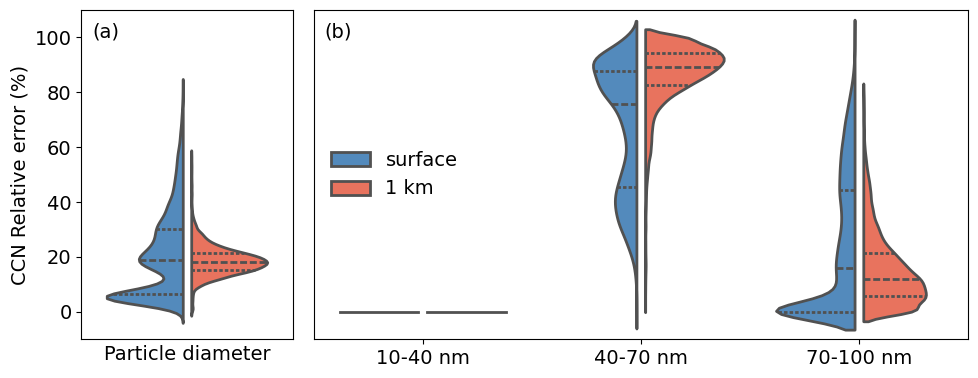

In [16]:
# Create a figure with a 1x4 grid of subplots
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 3, width_ratios=[1,  2, 1])

# Create subplots within the grid
axes = [fig.add_subplot(gs[0, 0]),  fig.add_subplot(gs[0, 1:3])]

sns.violinplot(data=sc_error_compare, y="error", x=np.zeros_like(sc_error_compare['error']), hue="type", gap=.1, palette=["#428BCD", "#FF6347"], linewidth=2, inner='quart', split=True, ax=axes[0])
axes[0].set_xticks([])
axes[0].get_legend().remove() 
axes[0].set_xlabel("Particle diameter")
axes[0].set_ylabel("CCN Relative error (%)")
axes[0].set_ylim(-10, 110)
axes[0].text(x =-0.45, y = 100, s='(a)')
axes[0].legend().remove()

sns.violinplot(data=df_combined, x="diam_range", y="error", hue="type", gap=.1, palette=["#428BCD", "#FF6347"], split=True, linewidth=2, inner='quart', ax=axes[1])
axes[1].set_yticks([])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(-10, 110)
axes[1].text(x =-0.45, y = 100, s='(b)')
axes[1].legend(loc=6,frameon=False)


plt.tight_layout()

# plt.savefig('ccn_rel_with_size.pdf', bbox_inches='tight',dpi=300)

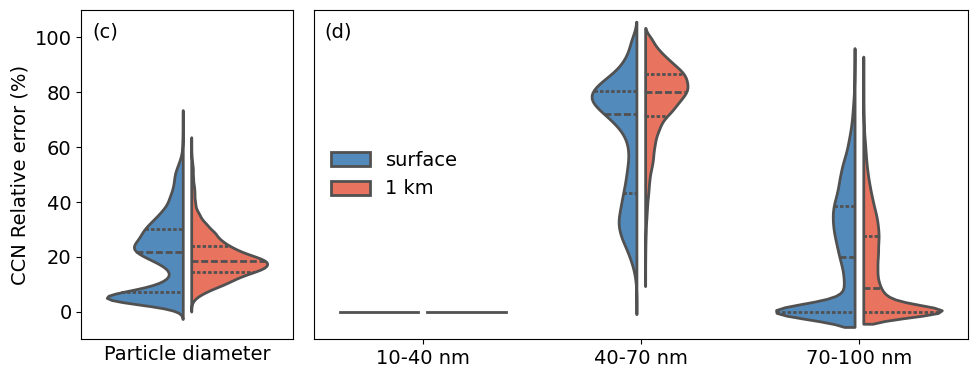

In [45]:
# Create a figure with a 1x4 grid of subplots
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 3, width_ratios=[1,  2, 1])

# Create subplots within the grid
axes = [fig.add_subplot(gs[0, 0]),  fig.add_subplot(gs[0, 1:3])]

sns.violinplot(data=sc_error_compare_12, y="error", x=np.zeros_like(sc_error_compare['error']), hue="type", gap=.1, palette=["#428BCD", "#FF6347"], linewidth=2, inner='quart', split=True, ax=axes[0])
axes[0].set_xticks([])
axes[0].get_legend().remove() 
axes[0].set_xlabel("Particle diameter")
axes[0].set_ylabel("CCN Relative error (%)")
axes[0].set_ylim(-10, 110)
axes[0].text(x =-0.45, y = 100, s='(c)')
axes[0].legend().remove()

sns.violinplot(data=df_combined_12, x="diam_range", y="error", hue="type", gap=.1, palette=["#428BCD", "#FF6347"], split=True, linewidth=2, inner='quart', ax=axes[1])
axes[1].set_yticks([])
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(-10, 110)
axes[1].text(x =-0.45, y = 100, s='(d)')
axes[1].legend(loc=6,frameon=False)


plt.tight_layout()

plt.savefig('ccn_rel_err_with_size_12.pdf', bbox_inches='tight',dpi=300)

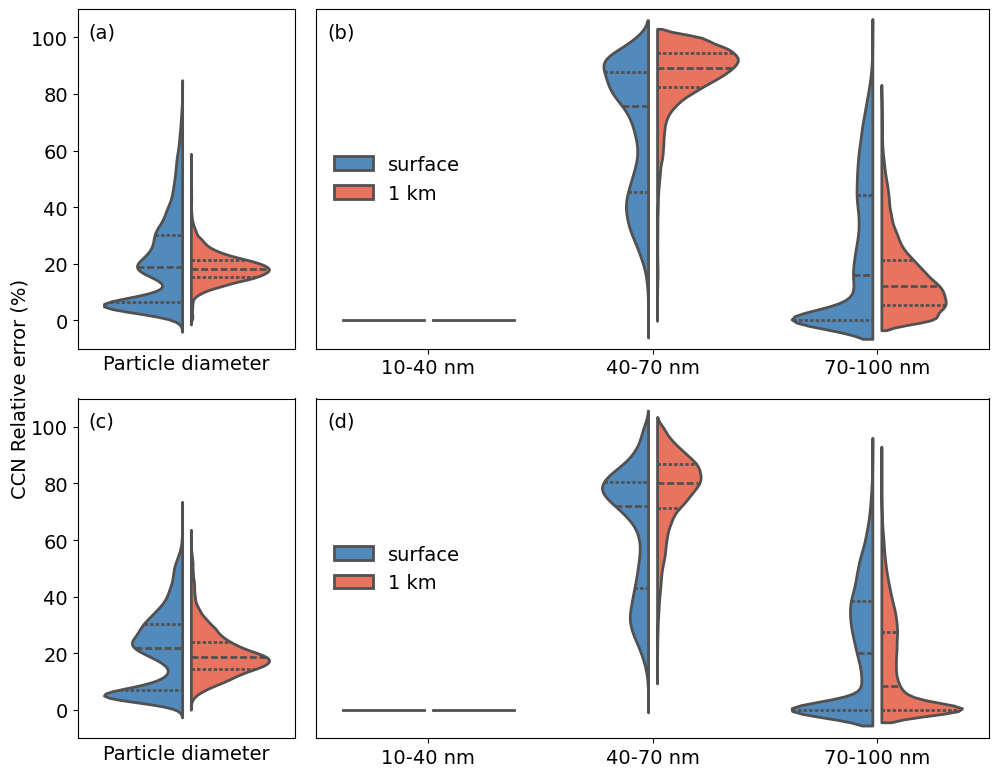

In [18]:
# Create a figure with a 2x2 grid of subplots
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 2, 1], height_ratios=[1, 1])

# Create subplots within the grid
axes = [
    [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1:3])],  # First row
    [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1:3])]   # Second row
]

# Function to plot violin plots
def plot_violin(ax_left, ax_right, data_left, data_right, title_left, title_right, ylabel_left=None, ylabel_right=None):
    # Plot left subplot
    sns.violinplot(data=data_left, y="error", x=np.zeros_like(data_left['error']), hue="type", gap=.1, 
                   palette=["#428BCD", "#FF6347"], linewidth=2, inner='quart', split=True, ax=ax_left)
    ax_left.set_xticks([])
    ax_left.get_legend().remove()
    ax_left.set_xlabel("Particle diameter")
    ax_left.set_ylabel(ylabel_left)
    ax_left.set_ylim(-10, 110)
    ax_left.text(x=-0.45, y=100, s=title_left)
    
    # Plot right subplot
    sns.violinplot(data=data_right, x="diam_range", y="error", hue="type", gap=.1, 
                   palette=["#428BCD", "#FF6347"], split=True, linewidth=2, inner='quart', ax=ax_right)
    ax_right.set_yticks([])
    ax_right.set_xlabel('')
    ax_right.set_ylabel('')
    ax_right.set_ylim(-10, 110)
    ax_right.text(x=-0.45, y=100, s=title_right)
    ax_right.legend(loc=6, frameon=False)

# Plot first row (sc_error_compare and df_combined)
plot_violin(axes[0][0], axes[0][1], sc_error_compare, df_combined, '(a)', '(b)')

# Plot second row (sc_error_compare_12 and df_combined_12)
plot_violin(axes[1][0], axes[1][1], sc_error_compare_12, df_combined_12, '(c)', '(d)')

fig.text(0, 0.5, 'CCN Relative error (%)', va='center', rotation='vertical')

# Adjust layout
plt.tight_layout()
plt.savefig('ccn_rel_err_with_size.pdf', bbox_inches='tight',dpi=300)
plt.show()